# Прогнозирование большого количества рядов

## 1. Подготовка данных

Для построения модели работы желтого такси в Нью-Йорке будем использовать агрегированные данные о количестве поездок &ndash; таблицу, в индексах строк которой указано время (по часам), а в столбцах указан идентификатор географического региона (ячейки), из которой совершалась поездка. Используя эти данные, выберем только более активные регионы &ndash; те, в которых среднее количество поездок в час превышает некоторый порог `region_activity_threshold`. Будем прогнозировать количество поездок желтого такси в каждом таком регионе отдельно. Т.е. модель работы желтого такси будет представлять собой совокупность отдельных моделей регионов. Общее количество моделей совпадает с количеством активных регионов и обозначается далее как $R$. Для построения моделей используем данные за 1 год с 01.05.2015 по 30.04.2016. Данные за май 2016 будем использовать для оценки совокупной модели. Данные за июнь 2016 используем для тестирования.

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMAResults
from matplotlib.collections import LineCollection
from sklearn import cluster, covariance, manifold
from itertools import product as prdct
from time import time
from datetime import timedelta
import os

WEEK_HOURLY = 168
CLUSTERS_DIR = 'cluster_results'
MODELS_DIR   = 'sarimax_models'

Populating the interactive namespace from numpy and matplotlib


In [2]:
region_activity_threshold = 5

In [3]:
agg_data = pd.read_csv(
    'agg_data_12plus2.csv', 
    header=0, sep=',', index_col=['hour_bin'], parse_dates=['hour_bin'])

agg_data.head(3)

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
hour_bin,,,,,,,,,,,,,,,,,,,,,
2015-05-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-05-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-05-01 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
agg_data.tail(3)

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
hour_bin,,,,,,,,,,,,,,,,,,,,,
2016-06-30 21:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-06-30 22:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-06-30 23:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
agg_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10248 entries, 2015-05-01 00:00:00 to 2016-06-30 23:00:00
Columns: 2500 entries, 1 to 2500
dtypes: int64(2500)
memory usage: 195.5 MB


In [6]:
train_data = agg_data[:pd.to_datetime('2016-04-30 23:00:00')]
train_data.tail(3)

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
hour_bin,,,,,,,,,,,,,,,,,,,,,
2016-04-30 21:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-04-30 22:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-04-30 23:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test_data = agg_data[pd.to_datetime('2016-05-01 00:00:00'):]
test_data.head(3)

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
hour_bin,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
activity_check_period = slice(
    pd.to_datetime('2016-05-01 00:00:00'), 
    pd.to_datetime('2016-05-31 23:00:00'))
regions_means = agg_data[activity_check_period].mean()
low_act_regions_indices = regions_means[regions_means <= region_activity_threshold].index
active_regions_agg_data = train_data.drop(columns=low_act_regions_indices)

In [9]:
active_regions_agg_data.tail(3)

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
hour_bin,,,,,,,,,,,,,,,,,,,,,
2016-04-30 21:00:00,91,155,108,115,318,463,600,875,831,152,...,2,0,2,190,67,129,16,158,81,117
2016-04-30 22:00:00,100,97,85,100,217,421,697,955,909,203,...,1,0,2,230,80,132,21,198,23,93
2016-04-30 23:00:00,92,118,63,86,284,529,733,838,918,185,...,4,0,0,195,54,134,10,181,74,39


In [10]:
R = active_regions_agg_data.shape[1]
R

102

Далее будем иметь дело только с наиболее активными регионами. Их число равно $R$.

In [11]:
active_regions_test_agg_data = test_data.drop(columns=low_act_regions_indices)
active_regions_history = pd.concat([active_regions_agg_data, active_regions_test_agg_data])

Стоит обратить внимание, что регионы 2168 и 2119 после 14.06.2016 ведут себя иначе, чем до этой даты. Это немного увеличит общую ошибку.

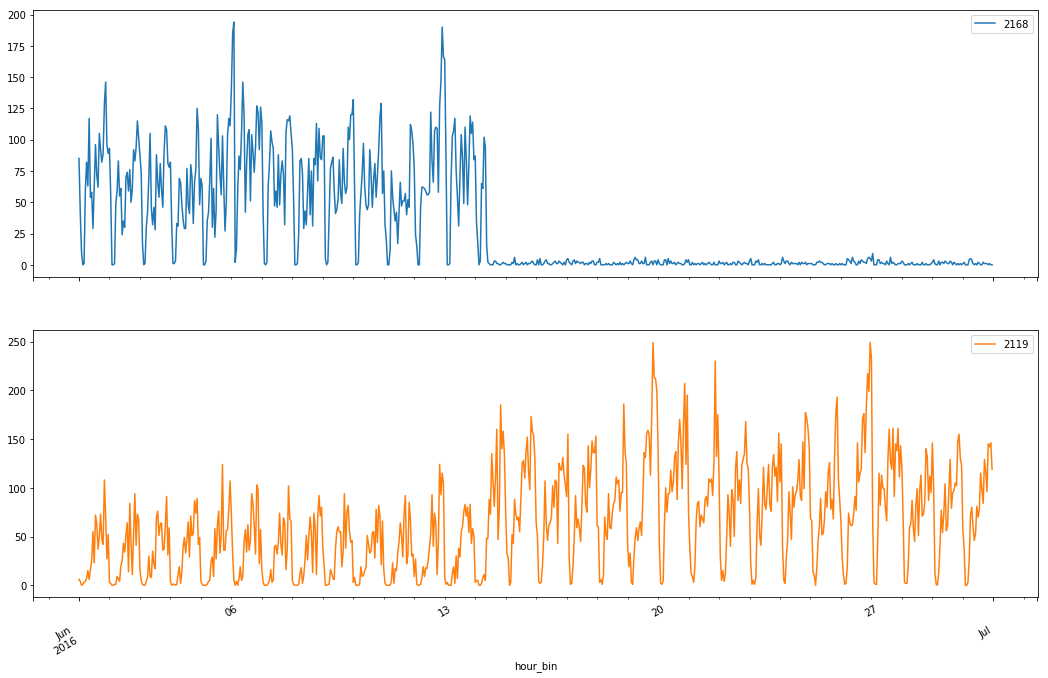

In [12]:
active_regions_history.loc[pd.to_datetime('2016-06-01 00:00:00'):, ['2168', '2119']].plot(
    subplots=True, 
    figsize=(18, 12))
plt.show()

## 2. Поиск похожих регионов

Так как нам предстоит построить $R$ разных моделей по одной для каждого активного региона, стоит поискать регионы, активность которых проявляется схожим образом. Исследование нескольких моделей с разными параметрами для одного региона позволит подобрать подходящие параметры и использовать их для построения моделей для всех регионов, сходных с исследованным.

Кластеризуем географические зоны по значениям стандартизованных рядов. Перед проведением кластеризации стандартизируем данные (вычтем выборочное среднее и поделим на выборочную дисперсию). Это имеет смысл, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний. Воспользуемся методом `affinity_propagation`, который предлагает библиотека `scikit-learn`. Выбранный метод способен автоматически подобрать достаточное количество кластеров, которые, к тому же, могут быть разных размеров.

Для достижения исследовательской цели возьмем только часть данных. Использование большего количества данных увеличивает количество кластеров.

In [13]:
active_regions_norm_agg_data = active_regions_agg_data.transform(lambda x: (x - x.mean()) / x.std())
active_regions_norm_agg_data.tail(3)

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
hour_bin,,,,,,,,,,,,,,,,,,,,,
2016-04-30 21:00:00,0.633444,0.241325,0.374767,1.197147,1.325609,1.378174,1.768263,2.697837,1.651802,0.133348,...,-0.651393,-0.896326,-0.775953,-0.142909,-0.781596,0.643207,0.703915,0.255417,1.441743,1.359933
2016-04-30 22:00:00,0.850457,-0.469208,-0.017244,0.818056,0.305312,1.076223,2.341713,3.107253,1.965631,0.776218,...,-0.860280,-0.896326,-0.775953,0.110617,-0.682183,0.693821,1.282410,0.776063,-0.461445,0.726104
2016-04-30 23:00:00,0.657556,-0.211946,-0.392211,0.464237,0.982142,1.852669,2.554540,2.508482,2.001842,0.549323,...,-0.233619,-0.896326,-1.163665,-0.111218,-0.881009,0.727563,0.009721,0.554789,1.212048,-0.700013


In [14]:
X_act_reg = active_regions_norm_agg_data.iloc[:31*24*2]

In [15]:
%%time
# #############################################################################
# Learn a graphical structure from the correlations
### gl_model = covariance.GraphicalLassoCV(cv=5)
gl_model = covariance.GraphLassoCV(cv=5)

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
gl_model.fit(X_act_reg)

# #############################################################################
# Cluster using affinity propagation
cluster_centers_indices, cluster_labels = cluster.affinity_propagation(gl_model.covariance_)
num_labels = cluster_labels.max()

Wall time: 15.5 s


In [16]:
cluster_centres = X_act_reg.columns[cluster_centers_indices]
region_to_cluster = dict(zip(X_act_reg.columns, cluster_labels))

In [17]:
for c_label in range(num_labels + 1):
    c = cluster_centres[c_label]
    print('Кластер {:2}, центр в {}:\n{}\n'
          .format((c_label + 1), c, ', '.join(X_act_reg.columns[cluster_labels == c_label])))

Кластер  1, центр в 1174:
1172, 1173, 1174, 1175, 1182, 1225

Кластер  2, центр в 1233:
1125, 1126, 1127, 1128, 1131, 1179, 1180, 1229, 1230, 1231, 1232, 1233, 1281

Кластер  3, центр в 1283:
1075, 1076, 1132, 1234, 1235, 1282, 1283, 1284, 1334, 1335, 1382

Кластер  4, центр в 1287:
1184, 1279, 1286, 1287, 1336, 1337, 1338, 1339, 1384, 1385, 1386, 1434

Кластер  5, центр в 1327:
1129, 1130, 1176, 1177, 1178, 1221, 1222, 1223, 1224, 1227, 1228, 1272, 1273, 1274, 1278, 1326, 1327, 1376, 1377, 1378, 1380, 1426, 1482, 1532, 1533, 1630

Кластер  6, центр в 1332:
1077, 1181, 1183, 1280, 1285, 1331, 1332, 1333, 1383

Кластер  7, центр в 1431:
1431

Кластер  8, центр в 1437:
1387, 1388, 1389, 1390, 1435, 1436, 1437, 1438, 1439, 1441

Кластер  9, центр в 1442:
1442

Кластер 10, центр в 1530:
1480, 1483, 1530, 1580

Кластер 11, центр в 1783:
1684, 1733, 1734, 1783

Кластер 12, центр в 2069:
2069

Кластер 13, центр в 2118:
2068, 2118, 2119, 2168



Для всех кластеров построим графики стандартизированных рядов, отнесенных к одному кластеру. Более темным цветом изображены наиболее типичные (центральные) ряды кластеров, а более светлым цветом &ndash; остальные ряды.

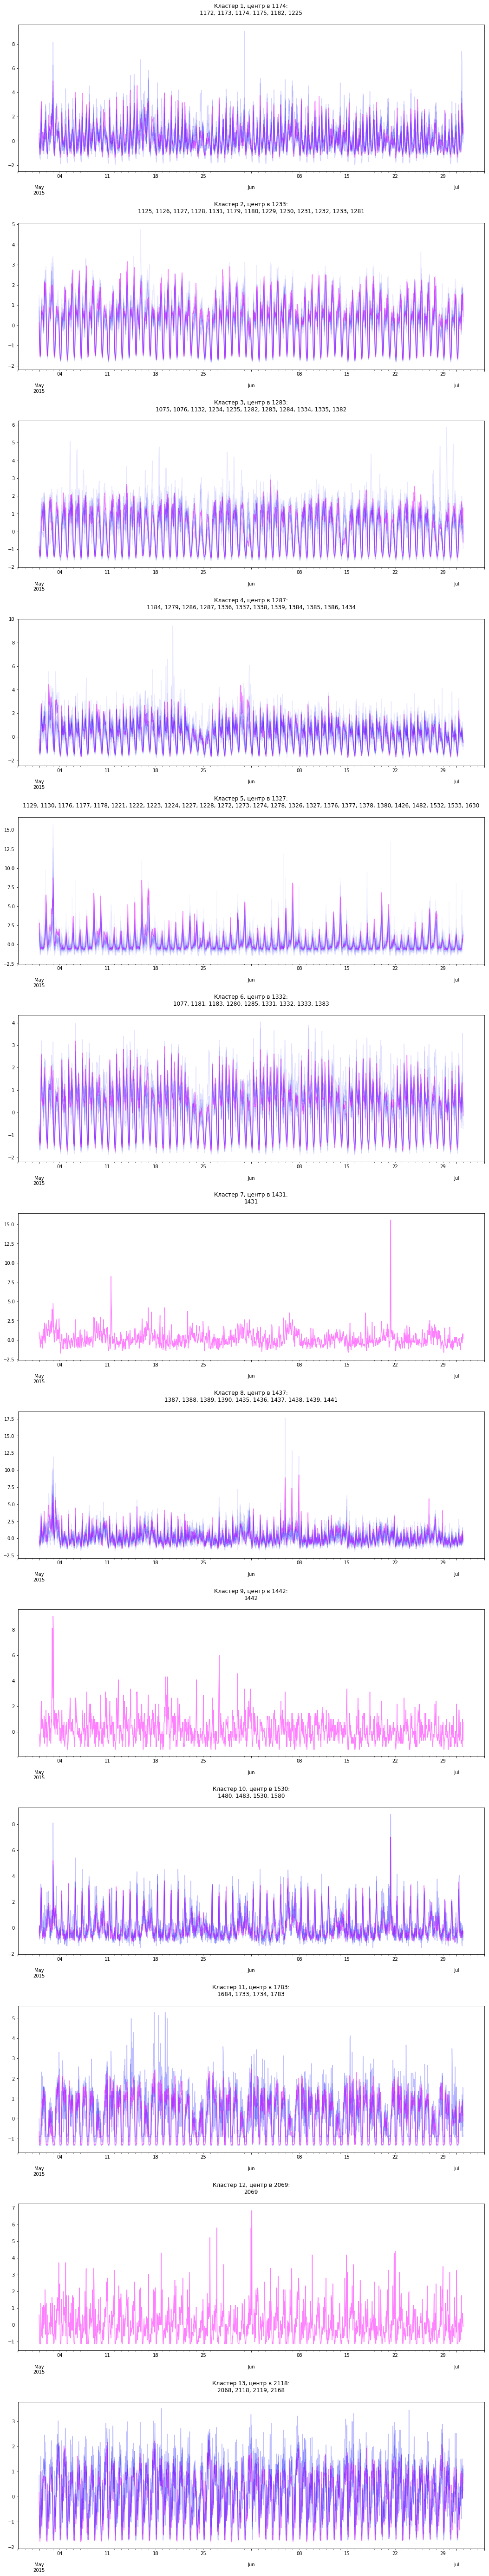

In [18]:
_, axs = plt.subplots(num_labels+1, 1, figsize=(18,100))
plt.subplots_adjust(hspace = .35)
center_color = '#FF00FF7F'
main_color   = '#0000FF'
for i in range(num_labels + 1):
    c = cluster_centres[i]
    ax = axs[i]
    df = X_act_reg.drop(columns=X_act_reg.columns[cluster_labels != i])
    colors = df.columns.values.copy()
    colors[colors == c] = center_color
    main_color_alpha = hex(255/df.shape[1])[-2:].replace('x', '0')
    colors[colors != center_color] = main_color + main_color_alpha
    df.plot(ax=ax, legend=False, color=colors)
    ax.set(
        title=u'Кластер {}, центр в {}:\n{}\n'
            .format((i + 1), c, ', '.join(X_act_reg.columns[cluster_labels == i])), 
        xlabel='')
plt.show()

Кроме этого, представим полученные кластеры в виде графа. Каждый кластер представлен совокупностью точек одинакового цвета. Оригинальный код можно посмотреть <a href="https://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html#sphx-glr-auto-examples-applications-plot-stock-market-py" target="_blank">здесь</a>

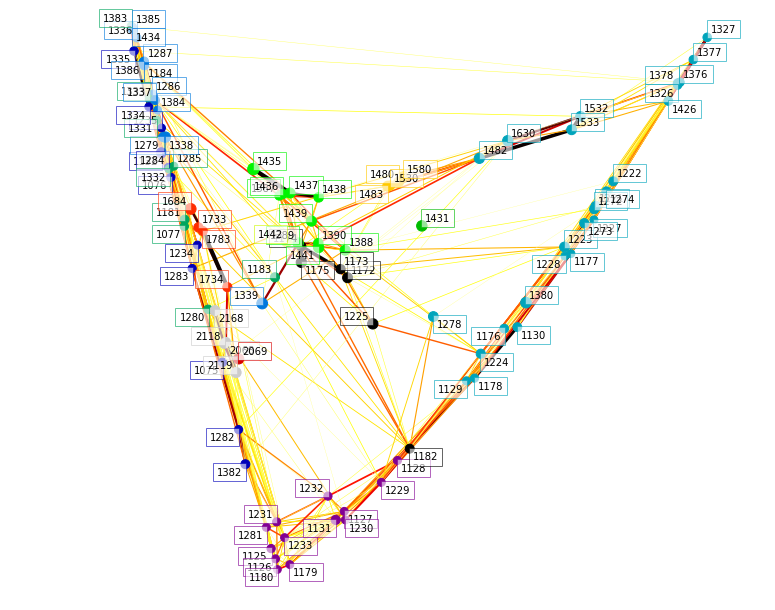

In [19]:
# Author: Gael Varoquaux gael.varoquaux@normalesup.org
# License: BSD 3 clause

# #############################################################################
# Find a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X_act_reg.T).T

# #############################################################################
# Visualization
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = gl_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=cluster_labels,
            cmap=plt.cm.nipy_spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(X_act_reg.columns, cluster_labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w', 
                       edgecolor=plt.cm.nipy_spectral(label / float(num_labels)), 
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()

## 3. Исследование центров кластеров

Предыдущие исследования показали, что использование в качестве единственного регрессионного признака сезонной компоненты STL декомпозиции, получаемой с помощью функции `tsa.seasonal_decompose` модуля `statsmodels.api`, вместо набора тригнометрических признаков, существенно снижает время построения модели ARIMA и, соответственно, время подбора ее оптимальных гиперпараметров $p,d,q,P,D,Q$. При этом качество почасовых и коротких динамических прогнозов, т.е. прогнозов не на один, а на несколько часов вперед, остается примерно одинаковым. Будем использовать сезонную компоненту в качестве экзогенного признака.

Выберем ряды, соответствующие центрам кластеров, для подбора значения гиперпараметров $p,d,q,P,D,Q$ моделей ARIMA. Выбранные значения будем использовать для построения моделей в кластере. Ввиду необходимости построить достаточно большое количество моделей, ограничим пространство поиска только лишь самыми простыми моделями, теми, которые не требуют значительных временных затрат на их построение. По каждому кластеру будем сохранять в файл параметры модели, значение критерия Акаике и время, затраченное на построение модели.

In [20]:
start_arima_params = [0, 0, 0, 0]
end_arima_params   = [2, 2, 1, 1]
d, D = 0, 0

params_ranges = [range(s, e+1) for (s,e) in zip(start_arima_params, end_arima_params)]
print('ps={}, d={d}, qs={}, Ps={}, D={D}, Qs={}'.format(d=d, D=D, *params_ranges))
parameters_list = list(prdct(*params_ranges))
len(parameters_list)

ps=[0, 1, 2], d=0, qs=[0, 1, 2], Ps=[0, 1], D=0, Qs=[0, 1]


36

In [21]:
def reg_model(data):
    formula = '{} ~ {}'.format(data.columns.values[0], ' + '.join(data.columns.values[1:]))
    model = smf.ols(formula, data)
    fitted = model.fit()
    return fitted.rsquared, sm.tsa.stattools.adfuller(fitted.resid)[1]

In [22]:
def time_str(t):
    return str(timedelta(seconds=round(t)))

In [23]:
def arima(parameters_list, d, D, endog, exog, verbose=False):
    results = []

    warnings.filterwarnings('ignore')

    for n, param in enumerate(parameters_list, 1):
        # на некоторых наборах параметров модель не обучается
        try:
            cur_time = time()
            model = sm.tsa.statespace.SARIMAX(
                endog=endog, 
                exog=exog,
                order=(param[0], d, param[1]),
                seasonal_order=(param[2], D, param[3], 24)
            ).fit(disp=1)
            training_time = time()-cur_time
            if verbose:
                training_time_str = time_str(training_time)
                print('\n{:>2}: верный набор параметров:   {}\nзатраченное время: {}, aic={:.1f}'\
                    .format(n, str(param), training_time_str, model.aic))
            results.append([param, model.aic, training_time])
        except:
            if verbose:
                print('{:>2}: неверный набор параметров: {}'.format(n, str(param)))

    warnings.filterwarnings('default')
    
    return results

In [24]:
if not os.path.exists(CLUSTERS_DIR):
    os.makedirs(CLUSTERS_DIR)
completed_centers_res = [int(f_name.split('_')[1]) for f_name in os.listdir(CLUSTERS_DIR)]
    
for i in range(num_labels + 1):
    if i+1 in completed_centers_res:
        print('Центр кластера {} уже исследован'.format(i+1))
        continue
    cur_time = time()
    print('\nИсследуется центр кластера {:2} - регион {}'.format(i+1, cluster_centres[i]))
    cluster_center_region_data = active_regions_agg_data.loc[:, cluster_centres[i]]
    data_decompose = sm.tsa.seasonal_decompose(
        cluster_center_region_data, 
        freq=WEEK_HOURLY)
    data_seasonal = data_decompose.seasonal.to_frame('seasonal_val')
    data_with_seasonal = cluster_center_region_data.to_frame('trip_count').join(data_seasonal)
    print('R_squared регрессионной модели: {:.2f}, \nзначение критерия Дики-Фуллера: {:.4f}'
          .format(*reg_model(data_with_seasonal)))
    results = arima(
        parameters_list, d, D, 
        endog=data_with_seasonal.trip_count, 
        exog=data_with_seasonal.seasonal_val)
    results_df = pd.DataFrame(results)
    results_df.columns = ['params', 'aic', 'training_time']
    results_df.to_csv('{}\cluster_{:0>2}_res.csv'.format(CLUSTERS_DIR, i+1))
    print('затраченное время: {:>20}'.format(time_str(time()-cur_time)))


Исследуется центр кластера  1 - регион 1174
R_squared регрессионной модели: 0.71, 
значение критерия Дики-Фуллера: 0.0000
затраченное время:              0:53:18

Исследуется центр кластера  2 - регион 1233
R_squared регрессионной модели: 0.89, 
значение критерия Дики-Фуллера: 0.0000
затраченное время:              1:05:21

Исследуется центр кластера  3 - регион 1283
R_squared регрессионной модели: 0.88, 
значение критерия Дики-Фуллера: 0.0000
затраченное время:              0:55:11

Исследуется центр кластера  4 - регион 1287
R_squared регрессионной модели: 0.78, 
значение критерия Дики-Фуллера: 0.0000
затраченное время:              0:59:27

Исследуется центр кластера  5 - регион 1327
R_squared регрессионной модели: 0.74, 
значение критерия Дики-Фуллера: 0.0000
затраченное время:              0:39:36

Исследуется центр кластера  6 - регион 1332
R_squared регрессионной модели: 0.88, 
значение критерия Дики-Фуллера: 0.0000
затраченное время:              1:07:33

Исследуется центр кла

***CHECKPOINT***

Гипотезы нестационарности остатков моделей центров всех кластеров уверенно отвергаются по критерию Дики-Фуллера – при построении модели ARIMA можно обойтись без дифференцирования остатков.

Восстановим из файлов результаты оценки моделей по критерию Акаике и затраченного на построение времени. Для подбора параметров моделей ранжируем результаты оценки по формуле:

$$\frac{k\dot\, AIC_p^k}{100\dot\, t_p}$$

- $AIC_p$ &ndash; отношение значения критерия Акаике ранжируемой модели к наименьшему (т.е. лучшему) значению критерия в данном кластере.
- $t_p$ &ndash; отношение времени, потраченного на построение модели к времени, потраченному на построение модели с наименьшим значением критерия Акаике,
- $k$ &ndash; параметр рейтинга. Чем больше $k$, тем важнее низкое значения критерия Акаике и второстепенней потери времени на построение модели и прогнозирование с помощью нее. И, наоборот, при малых значениях $k$ важнее затрачиваемое время и второстепенней низкое значение критерия, т.е. качество модели. Таким образом, при разных значениях параметра $k$ будем получать разные ранжирования моделей в зависимости от желаемого баланса важности между низким значением критерия и временны&#769;ми затратами. При малом $k$ &#171;быстрые&#187; модели будут иметь более высокий рейтинг, при большом $k$ иметь более высокий рейтинг будут модели более качественные.

Таким образом, получаем рейтинги параметров моделей регионов одного кластера, которые будем использовать при выборе параметров моделей. Ранжирование моделей облегчает отладку и тестирование кода, снижая затраченное время, а также позволяет оценить влияние значение критерия Акаике на качество модели.

In [25]:
results = [pd.read_csv('{}\{}'.format(CLUSTERS_DIR, f_name), index_col=0) 
           for f_name in sorted(os.listdir(CLUSTERS_DIR))]

In [26]:
## k = 60
k = 1000
cluster_arima_parameters = []
n = 3
print('Топ-{} моделей с самыми высокими рейтингами в каждом кластере, k={}\n'
      .format(n,k))
for df in results:
    sorted_df = df.sort_values(by=['aic'])
    aic_min = sorted_df.iloc[0].aic
    training_time_of_aic_min = sorted_df.iloc[0].training_time
    sorted_df['aic_p'] = aic_min / sorted_df.aic
    sorted_df['training_time_p'] = sorted_df.training_time / training_time_of_aic_min
    sorted_df['rating'] = k * (sorted_df.aic_p ** k) / sorted_df.training_time_p / 100
    sorted_df = sorted_df.sort_values(by=['rating'], ascending=False)
    arima_params = sorted_df.params.transform(eval).values
    cluster_arima_parameters.append(arima_params)
    print(sorted_df[['params', 'training_time', 'aic_p', 'training_time_p', 'rating']].iloc[:n])

Топ-3 моделей с самыми высокими рейтингами в каждом кластере, k=1000

          params  training_time     aic_p  training_time_p     rating
31  (2, 1, 1, 1)        171.817  0.999901         0.679038  13.338419
35  (2, 2, 1, 1)        253.030  1.000000         1.000000  10.000000
34  (2, 2, 1, 0)        176.045  0.998550         0.695748   3.366602
          params  training_time     aic_p  training_time_p     rating
30  (2, 1, 1, 1)        198.842  0.999755         0.741668  10.557337
34  (2, 2, 1, 1)        268.101  1.000000         1.000000  10.000000
29  (2, 1, 1, 0)        195.841  0.996885         0.730475   0.604485
          params  training_time     aic_p  training_time_p     rating
31  (2, 2, 1, 1)        259.036  1.000000         1.000000  10.000000
19  (1, 1, 1, 1)        151.879  0.995832         0.586324   0.261659
15  (1, 0, 1, 1)         96.928  0.995355         0.374187   0.253952
          params  training_time     aic_p  training_time_p     rating
35  (2, 2, 1, 1)    

## 4. Построение моделей регионов
Построим модели, используя рейтинг параметров. Вначале пробуем параметры с самым высоким рейтингом. Если такие параметры не подходят для данной модели, то выбираем ближайшие по рейтингу параметры, и так до тех пор, пока не будут найдены подходящие параметры. Построенные модели сохраним в файлы.

In [27]:
def arima_params_generator(lst):
    for x in lst: yield x

In [28]:
%%time
# 2 секунды для одного региона по рейтингу k60, около 3 минут для всех моделей
# 4 минуты для одного региона по рейтингу k1000, около 6.5 часов для всех моделей

d, D = 0, 0

model_num = 0
models = {}

models_dir_name = MODELS_DIR+'_k'+str(k)
if not os.path.exists(models_dir_name):
    os.makedirs(models_dir_name)
completed_models_regions = [f_name.split('_')[1] for f_name in os.listdir(models_dir_name)]
    
warnings.filterwarnings('ignore')
for cluster_label, (region, region_data) in \
    zip(cluster_labels, active_regions_agg_data.iteritems()):
    if region in completed_models_regions:
        print('Модель для региона {} уже существует'.format(region))
        continue;
    cur_time = time()
    model_num += 1
    params_gen = arima_params_generator(cluster_arima_parameters[cluster_label])
    params = params_gen.next()
    print('\nСтроится модель: {}\nдля региона: {}\nиз кластера: {}'
          .format(model_num, region, cluster_label+1))
    print('параметры модели: p={}, d={d}, q={}, P={}, D={D}, Q={}'.format(d=d, D=D, *params))
    
    data_decompose = sm.tsa.seasonal_decompose(
        region_data, 
        freq=WEEK_HOURLY)
    data_seasonal = data_decompose.seasonal.to_frame('seasonal_val')
    data_with_seasonal = region_data.to_frame('trip_count').join(data_seasonal)
    
    model_built = False
    while not model_built:
        try:
            model = sm.tsa.statespace.SARIMAX(
                endog=data_with_seasonal.trip_count, 
                exog=data_with_seasonal.seasonal_val, 
                order=(params[0], d, params[1]), 
                seasonal_order=(params[2], D, params[3], 24)
            ).fit(disp=1)
            model_built = True
        except:
            params = params_gen.next()
            print('----> неверные параметры <----')
            print('параметры модели: p={}, d={d}, q={}, P={}, D={D}, Q={}'
                  .format(d=d, D=D, *params))
    models[str(region)] = model
    model.save(
        '{m_dir}\model_{r}_({},{d},{},{},{D},{}).pkl'
        .format(m_dir=models_dir_name, r=region, d=d, D=D, *params), 
        remove_data=True)
    print('затраченное время: {}'.format(time_str(time()-cur_time)))
warnings.filterwarnings('default')


Строится модель: 1
для региона: 1075
из кластера: 3
параметры модели: p=2, d=0, q=2, P=1, D=0, Q=1
затраченное время: 0:03:58
Модель для региона 1076 уже существует
Модель для региона 1077 уже существует
Модель для региона 1125 уже существует
Модель для региона 1126 уже существует
Модель для региона 1127 уже существует
Модель для региона 1128 уже существует
Модель для региона 1129 уже существует
Модель для региона 1130 уже существует
Модель для региона 1131 уже существует
Модель для региона 1132 уже существует
Модель для региона 1172 уже существует
Модель для региона 1173 уже существует
Модель для региона 1174 уже существует
Модель для региона 1175 уже существует
Модель для региона 1176 уже существует
Модель для региона 1177 уже существует
Модель для региона 1178 уже существует
Модель для региона 1179 уже существует
Модель для региона 1180 уже существует
Модель для региона 1181 уже существует
Модель для региона 1182 уже существует
Модель для региона 1183 уже существует
Модель для реги

***CHECKPOINT***

## 5. Прогнозирование
Восстановим из файлов сохраненные модели. Для прогнозирования с помощью них, нам требуются экзогенные признаки. В качестве них были использованы сезонные компоненты STL-декомпозиции. Для каждого ряда данных (региона) продолжим его сезонный тренд на тестовые данные. Добавим необходимый для этого функционал.

In [29]:
def add_weekdays(data):
    ws = pd.DataFrame(
        list(map(lambda x: int(x.strftime('%w')), data.index)), 
        columns=['weekday'])
    ws.index = data.index
    return data.join(ws)

In [30]:
def seasonal_vals(data, s_vals):
    sv = s_vals.loc[
        map(lambda x: (x[0], int(x[1])),
            map(lambda x: x.split(),
                map(lambda x: getattr(x, 'strftime')('%H %w'), 
                    data.index)))]
    sv.index = data.index
    return sv

In [31]:
data_decompose = sm.tsa.seasonal_decompose(active_regions_agg_data, freq=WEEK_HOURLY)
data_seasonal = data_decompose.seasonal

s_vals = add_weekdays(data_seasonal[:WEEK_HOURLY])
s_vals['hour'] = map(lambda x: getattr(x, 'strftime')('%H'), s_vals.index)
s_vals.index = [s_vals.hour, s_vals.weekday]
s_vals.drop(columns=['hour', 'weekday'], inplace=True)

active_regions_history_seasonals = seasonal_vals(active_regions_history, s_vals=s_vals)

In [32]:
def restore_model(fname, order, seasonal_order, endog, exog):
    fit_res = ARIMAResults.load(fname)
    warnings.filterwarnings('ignore')
    mod = sm.tsa.statespace.SARIMAX(
        endog=endog, 
        exog=exog, 
        order=order, 
        seasonal_order=seasonal_order)
    warnings.filterwarnings('default')
    return mod.filter(fit_res.params)

In [33]:
## models_dir_name = 'sarimax_models_k60'
models_dir_name = 'sarimax_models_k1000'
models_params = {}
for model_fname in sorted(os.listdir(models_dir_name)):
    _, region, arima_params = model_fname.split('_')
    arima_params = eval(arima_params[:-4])
    order, seasonal_order = arima_params[:3], arima_params[3:]+(24,)
    models_params[region] = (models_dir_name+'\\'+model_fname, order, seasonal_order)

In [34]:
def period_generator(start, end, step='6H', freq='H'):
    for d in pd.date_range(start, end, freq=freq):
        yield d, d+pd.Timedelta('1H'), d+pd.Timedelta(step)

Построим прогнозы и сохраним результаты отдельно по каждому региону в файлы.

In [35]:
def predict_save(model, region, start, end, output_dir):
    print('Строится прогноз для региона {}'.format(region))
    ids = []
    ys = []
    history = []
    predict_period = period_generator(start, end)
    for end_history, start_predict, end_predict in predict_period:
        predict = model\
            .get_prediction(dynamic=str(start_predict))\
            .predicted_mean[start_predict:end_predict]
        d = end_history.date()
        h = end_history.hour
        current_ids = ['{}_{}_{}_{}'.format(region, d, h, p) for p in range(1,7)]
        ids += current_ids
        ys  += list(predict.values)
        hs = active_regions_history[region][start_predict:end_predict]
        history += list(hs.values)
    df = pd.DataFrame({'ys':ys, 'history':history}, index=ids)
    df.to_csv(output_dir+'\\'+'predicts_{}_reg.csv'.format(region))

In [36]:
def completed_predictions(output_dir):
    return [f_name.split('_')[1] for f_name in os.listdir(output_dir)]

def restore_model_wrapped(model, params):
    if type(model) == type(None):
        full_fname = params[0]
        print('Восстанавливается модель из файла {}'.format(full_fname))
        return restore_model(*params)
    else:
        return model

def restore_predict_save(model, model_params, region, start, end, completed_predictions, output_dir):
    if region not in completed_predictions:
        model = restore_model_wrapped(model, model_params)
        predict_save(
            model, region, 
            start, 
            end, 
            output_dir)
    else:
        print('В директории {} прогноз для региона {} уже существует'.format(output_dir, region))
    return model

def predictions(models_params, endogs, exogs, vldt_output_dir, test_output_dir):
    completed_vldt_predictions = completed_predictions(vldt_output_dir)
    completed_test_predictions = completed_predictions(test_output_dir)
    for region, (full_fname, order, seasonal_order) in models_params.items():
        model = None
        model_params = [full_fname, order, seasonal_order, endogs[region], exogs[region]]
        model = restore_predict_save(
            model, model_params, region, 
            start='2016-04-30 23:00:00', 
            end  ='2016-05-31 17:00:00', 
            completed_predictions=completed_vldt_predictions, 
            output_dir=vldt_output_dir)
        model = restore_predict_save(
            model, model_params, region, 
            start='2016-05-31 23:00:00', 
            end  ='2016-06-30 17:00:00', 
            completed_predictions=completed_test_predictions, 
            output_dir=test_output_dir)

In [37]:
%%time
# 1.5 минуты для одного региона по рейтингу k60, около 2.5 часов для всех моделей
# 8 минут для одного региона по рейтингу k1000, около 13.5 часов для всех моделей
vldt_output_dir = models_dir_name + '_vldt_predicts'
if not os.path.exists(vldt_output_dir):
    os.makedirs(vldt_output_dir)
test_output_dir = models_dir_name + '_test_predicts'
if not os.path.exists(test_output_dir):
    os.makedirs(test_output_dir)

predictions(
    models_params, 
    endogs=active_regions_history, 
    exogs=active_regions_history_seasonals, 
    vldt_output_dir=vldt_output_dir, 
    test_output_dir=test_output_dir)

Восстанавливается модель из файла sarimax_models_k1000\model_1783_(2,0,2,0,0,0).pkl
Строится прогноз для региона 1783
Строится прогноз для региона 1783
В директории sarimax_models_k1000_vldt_predicts прогноз для региона 1076 уже существует
В директории sarimax_models_k1000_test_predicts прогноз для региона 1076 уже существует
В директории sarimax_models_k1000_vldt_predicts прогноз для региона 1077 уже существует
В директории sarimax_models_k1000_test_predicts прогноз для региона 1077 уже существует
В директории sarimax_models_k1000_vldt_predicts прогноз для региона 1075 уже существует
В директории sarimax_models_k1000_test_predicts прогноз для региона 1075 уже существует
В директории sarimax_models_k1000_vldt_predicts прогноз для региона 1377 уже существует
В директории sarimax_models_k1000_test_predicts прогноз для региона 1377 уже существует
В директории sarimax_models_k1000_vldt_predicts прогноз для региона 1376 уже существует
В директории sarimax_models_k1000_test_predicts прогноз 

*** CHECKPOINT ***

Прогнозы отдельно по каждому региону сохранены в файлах. Используем их для расчета ошибки прогноза по следующему функционалу: $$Q_{may}=\frac{1}{R\cdot739\cdot6}\sum_{r=1}^{R}\sum_{T=2016.04.30\,23:00}^{2016.05.31\,17:00}\sum_{i=1}^{6}\big\lvert\,\hat{y}_{T{\mid}T+i}^{r}-y_{T+i}^{r}\big\rvert\;.$$
Параметр $R$ показывает количество географических зон, для которых были построены модели и прогнозы. Параметр определялся по порогу `region_activity_threshold` активности зон.

In [38]:
## predicts_dir_name = 'sarimax_models_k60_vldt_predicts'
predicts_dir_name = 'sarimax_models_k1000_vldt_predicts'
predicts = {
    f_name.split('_')[1] : pd.read_csv('{}\{}'.format(predicts_dir_name, f_name), index_col=0) 
    for f_name in os.listdir(predicts_dir_name)}

In [39]:
q_coef = 739*6
predicts_errors = {}
for region, predict in predicts.items():
    predicts_errors[region] = sum(abs(predict.ys - predict.history)) / q_coef

In [40]:
round(sum(predicts_errors.values())/R, 5)
## k=60,   Q=22.52230
## k=1000, Q=17.29857

17.29857

In [41]:
print(round((22.52230-17.29857)/17.29857*100, 1))
print(round((8+4)/1.5, 1))

30.2
8.0


Можно отметить, что улучшение качества модели на $30\%$ потребовало увеличения временных затрат в $8$ раз.

Дополнительно отобразим с помощью линейчатой диаграммы величину ошибки модели каждого региона. Цветом покажем принадлежность региона кластеру.

In [42]:
region_to_cluster_color = {
    region : plt.cm.nipy_spectral(c_label / float(num_labels)) 
    for region, c_label in region_to_cluster.items()}
barh_cluster_colors = [region_to_cluster_color[region] for region in predicts_errors.keys()]

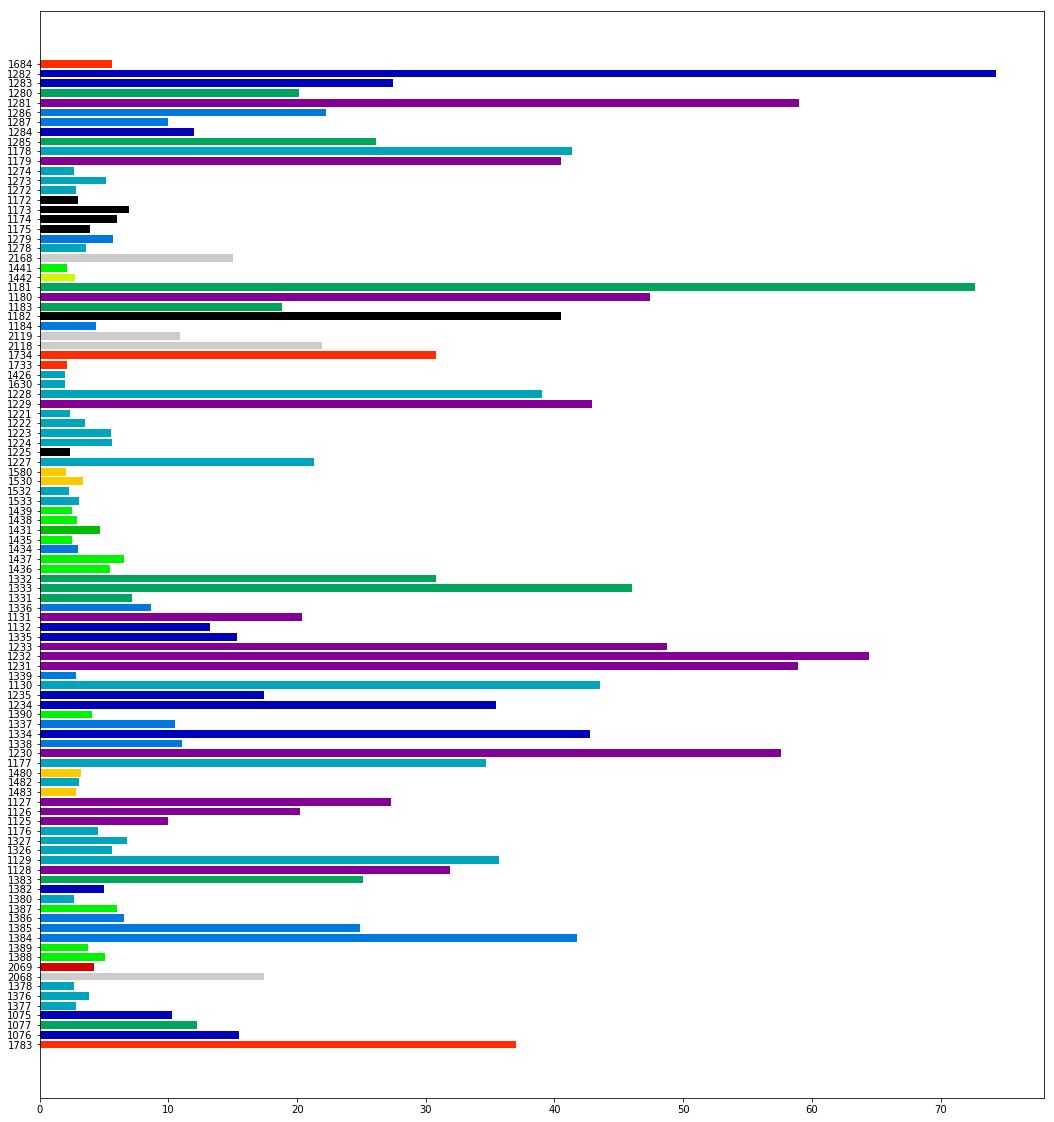

In [43]:
figure(figsize=(18,20))
plt.barh(range(len(predicts_errors)), list(predicts_errors.values()), align='center', 
         color=barh_cluster_colors)
plt.yticks(range(len(predicts_errors)), list(predicts_errors.keys()))
plt.show()

Соберем в один файл 'predicts.csv' все построенные прогнозы за тестовый период.

In [44]:
#predicts_dir_name = 'sarimax_models_k60_test_predicts'
predicts_dir_name = 'sarimax_models_k1000_test_predicts'

predicts = [pd.read_csv('{}\{}'.format(predicts_dir_name, f_name), index_col=0) 
            for f_name in sorted(os.listdir(predicts_dir_name))]
predicts = pd.concat(predicts)
predicts = predicts.drop(columns=['history'])
predicts.index.names = ['id']
predicts.columns = ['y']
predicts.to_csv('predicts.csv')

In [45]:
predicts.shape[0]
#437580

437580

Результаты оценки прогнозов на тестовых данных можно посмотреть на странице по ссылке [Жёлтое такси](https://inclass.kaggle.com/c/yellowtaxi/leaderboard), Team Name: Anton Frolenkov.